In [1]:
import projectpath

import abc
import collections
from dataclasses import dataclass
from importlib import resources
import time
from typing import Any, Callable, Iterable, Mapping, Optional, Tuple, Union

import escher
import ipywidgets as widgets
import jax
import jax.numpy as jnp
import bokeh.models
import bokeh.plotting as plt
import numpy as np
import pandas as pd
import panel as pn
import scipy

import files.pw
from kb import kb
from sim import fba_gd
from model.core import KbEntry, Molecule, Reaction, Pathway
from model.reaction_network import ReactionNetwork

ArrayT = Union[np.ndarray, jnp.ndarray]
jax.config.update('jax_enable_x64', True)
prng = jax.random.PRNGKey(int(time.time() * 1000))  # Gets the No GPU warning out of the way

plt.output_notebook()

KB = kb.configure_kb()

def labels(entries: Union[KbEntry, Iterable[KbEntry]]):
    if isinstance(entries, KbEntry):
        entries.shorthand or entries.id
    else:
        return [entry.shorthand or entry.id for entry in entries]

Loading BokehJS ...

## Glycolysis, Pentose Phosphate, and Entner-Doudoroff

In [2]:
network = ReactionNetwork()
for pw_name in ['glycolysis', 'pentose phosphate', 'entner-doudoroff']:
    pws = KB.find(KB.pathways, pw_name)
    if not pws:
        raise ValueError(f'{pw_name} not found in {KB.pathways}')
    if len(pws) > 1:
        print(f'Multiple hits to "{pw_name}"')
    for pw in pws:
        for step in pw.steps:
            network.add_reaction(step)

# TODO: Decide is it reasonable to track intermediates as part of a pathway definition? Or is that always contextual?
intermediates = [KB.get(KB.compounds, met_id) for met_id in  (
    'Fru.D.6P',
    'Fru.D.bis16',
    'dhap',
    'gap',
    'dpg',
    '3pg',
    '2pg',
    'pep',
    'pyr',
    '6pgdl',
    '6pg',
    'Rib.D.5P',
    'Rul.D.5P',
    'Xul.D.5P',
    'Sed.D.7P',
    'Ery.D.4P',
    'kdpg',
)]
boundaries = [met for met in network.reactants() if met not in intermediates]

print(f'Network has {network.shape[0]} reactants ({len(intermediates)} intermediates + {len(boundaries)} boundaries) in {network.shape[1]} reactions')


Network has 31 reactants (17 intermediates + 14 boundaries) in 22 reactions


In [3]:
fba = fba_gd.FbaGd(network, intermediates, {
    'carbon': fba_gd.ProductionObjective(network, {KB.get(KB.compounds, 'accoa'): 2}),
    'redox': fba_gd.VelocityObjective(network, {KB.get(KB.reactions, 'pgldh'): 1, KB.get(KB.reactions, 'pgldhat'): 1}),
}, w_fitness=1e6)
fba.solve()  # Forces jit

%timeit fba.solve()

34.2 ms ± 2.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
fba.solve()

FbaResult(v0=DeviceArray([-2.18901868, -0.39478526, -0.33054513, -1.05975695,
             -0.01685814,  2.37176778,  0.00249938,  2.07583884,
              0.14238121, -1.17084054,  0.47543758, -0.16676997,
              0.26159737,  0.0262444 ,  0.38403611, -1.0907714 ,
             -0.04079644, -1.14366655,  0.41363523,  0.18064089,
              0.49182404, -0.92891077], dtype=float64), velocities=array([-0.83329406,  0.34028414,  0.50595636, -0.16567232,  0.16567253,
        1.00141223, -1.00141209, -1.0014123 ,  1.00141242, -1.03714792,
        0.0357353 ,  2.00035874, -0.33381101, -0.33381098,  0.66762196,
        2.00037955,  1.00143297,  0.333811  ,  0.33381099,  2.00037979,
        0.99894614,  0.99894643]), dmdt=array([-1.16708573e+00,  1.44069786e-07,  1.66254058e+00, -1.69827587e+00,
        9.92182587e-08,  4.37677839e+00, -5.41712361e-01, -4.59720573e-01,
        1.91329286e-08,  2.12520888e-07, -3.00177097e+00,  1.38310052e-07,
        3.00177097e+00, -2.12648207e-07, -

## Interface stuff

In [31]:
pgi = KB.get(KB.reactions, 'pgi')
pgldh = KB.get(KB.reactions, 'pgldh')
pgldhat = KB.get(KB.reactions, 'pgldhat')

fba_kinetic = fba_gd.FbaGd(network, intermediates, {
    'fluxes': fba_gd.VelocityObjective(network, {
        pgi: 2,
        pgldh: 0,
        pgldhat: 0,
        # KB.get(KB.reactions, 'fbp'): 0,
        # KB.get(KB.reactions, 'pps'): 0,
    })})
fba_soln = fba_kinetic.solve()

diag = escher.Builder(
    width=600,
    height=600,
    map_json=resources.read_text(files.pw, 'glycolysis_ppp_ed.json'),
    # map_json=resources.read_text(files.pw, 'central_carbon.json'),
    menu='zoom',
    enable_editing=False,
    never_ask_before_quit=True,
    reaction_data={r: v for r, v in zip(labels(network.reactions()), fba_soln.velocities)},
    reaction_styles = ['abs', 'color', 'size',],
    reaction_scale = [
        {'type': 'value', 'value': 0, 'color': '#eeeeee', 'size': 3},
        {'type': 'value', 'value': 5, 'color': '#1f77b4', 'size': 20},
    ],
)

bflux_plot = plt.figure(
    title = 'Boundary Flux',
    width = 300,
    height = 200,
    tools=[],
    x_range=labels(boundaries),
    y_range=(-10, 10),
)
bflux_plot.xaxis.major_label_orientation = np.pi/4
bflux_data = bokeh.models.ColumnDataSource({'met': labels(network.reactants()), 'dmdt': fba_soln.dmdt})
bflux_view = bokeh.models.CDSView(
    source=bflux_data,
    filters=[bokeh.models.IndexFilter([network.reactant_index(b) for b in boundaries])]
)
bars = bflux_plot.vbar(
    source = bflux_data,
    view = bflux_view,
    x = 'met',
    top = 'dmdt',
    width=0.5,
    color='#1f77b4',
)

target_pgi = widgets.FloatSlider(
    value=2,
    min=0,
    max=5.0,
    step=0.1,
    description='Glycolysis',
    continuous_update=False,
    readout=True,
    readout_format='.1f',
)
target_pgldh = widgets.FloatSlider(
    value=0,
    min=0,
    max=5.0,
    step=0.1,
    description='PPP',
    continuous_update=False,
    readout=True,
    readout_format='.1f',
)
target_pgldhat = widgets.FloatSlider(
    value=0,
    min=0,
    max=5.0,
    step=0.1,
    description='ED',
    continuous_update=False,
    readout=True,
    readout_format='.1f',
)

def update_fba_kinetic(change):
    fba_kinetic.update_params({'fluxes': {pgi: target_pgi.value, pgldh: target_pgldh.value, pgldhat: target_pgldhat.value}})
    fba_soln = fba_kinetic.solve()
    diag.reaction_data = {r: v for r, v in zip(labels(network.reactions()), fba_soln.velocities)}
    bflux_data.data['dmdt'] = fba_soln.dmdt

target_pgi.observe(update_fba_kinetic, names='value')
target_pgldh.observe(update_fba_kinetic, names='value')
target_pgldhat.observe(update_fba_kinetic, names='value')

dashboard = widgets.HBox(
    [widgets.VBox([diag], layout = widgets.Layout(width='60%', height='100%')),
     widgets.VBox([
         target_pgi,
         target_pgldh,
         target_pgldhat,
         pn.ipywidget(bflux_plot)
     ], layout = widgets.Layout(width='40%', height='100%'))],
    layout = widgets.Layout(width='900px', height='600px', border='1px solid green')
)
dashboard

In [32]:
acCoA = KB.get(KB.compounds, 'accoa')
atp = KB.get(KB.compounds, 'atp')
nadph = KB.get(KB.compounds, 'nadp.red')

fba_mets = fba_gd.FbaGd(network, intermediates, {'mets': fba_gd.ProductionObjective(network, {acCoA: 2, atp: 3, nadph: 0})})
fba_soln = fba_mets.solve()

diag = escher.Builder(
    width=600,
    height=600,
    map_json=resources.read_text(files.pw, 'glycolysis_ppp_ed.json'),
    # map_json=resources.read_text(files.pw, 'central_carbon.json'),
    menu='zoom',
    enable_editing=False,
    never_ask_before_quit=True,
    reaction_data={r: v for r, v in zip(labels(network.reactions()), fba_soln.velocities)},
    reaction_styles = ['abs', 'color', 'size',],
    reaction_scale = [
        {'type': 'value', 'value': 0, 'color': '#eeeeee', 'size': 3},
        {'type': 'value', 'value': 5, 'color': '#1f77b4', 'size': 20},
    ],
)

bflux_plot = plt.figure(
    title = 'Boundary Flux',
    width = 300,
    height = 200,
    tools=[],
    x_range=labels(boundaries),
    y_range=(-10, 10),
)
bflux_plot.xaxis.major_label_orientation = np.pi/4
bflux_data = bokeh.models.ColumnDataSource({'met': labels(network.reactants()), 'dmdt': fba_soln.dmdt})
bflux_view = bokeh.models.CDSView(
    source=bflux_data,
    filters=[bokeh.models.IndexFilter([network.reactant_index(b) for b in boundaries])]
)
bars = bflux_plot.vbar(
    source = bflux_data,
    view = bflux_view,
    x = 'met',
    top = 'dmdt',
    width=0.5,
    color='#1f77b4',
)

target_accoa = widgets.FloatSlider(
    value=2,
    min=0,
    max=5.0,
    step=0.1,
    description='acCoA',
    continuous_update=False,
    readout=True,
    readout_format='.1f',
)
target_atp = widgets.FloatSlider(
    value=3,
    min=0,
    max=5.0,
    step=0.1,
    description='ATP',
    continuous_update=False,
    readout=True,
    readout_format='.1f',
)
target_nadph = widgets.FloatSlider(
    value=0,
    min=0,
    max=5.0,
    step=0.1,
    description='NADPH',
    continuous_update=False,
    readout=True,
    readout_format='.1f',
)

def update_fba_mets(change):
    fba_mets.update_params({'mets': {acCoA: target_accoa.value, atp: target_atp.value, nadph: target_nadph.value}})
    fba_soln = fba_mets.solve()
    diag.reaction_data = {r: v for r, v in zip(labels(network.reactions()), fba_soln.velocities)}
    bflux_data.data['dmdt'] = fba_soln.dmdt

target_accoa.observe(update_fba_mets, names='value')
target_atp.observe(update_fba_mets, names='value')
target_nadph.observe(update_fba_mets, names='value')

dashboard = widgets.HBox(
    [widgets.VBox([diag], layout = widgets.Layout(width='60%', height='100%')),
     widgets.VBox([
         target_accoa,
         target_atp,
         target_nadph,
         pn.ipywidget(bflux_plot)
     ], layout = widgets.Layout(width='40%', height='100%'))],
    layout = widgets.Layout(width='900px', height='600px', border='1px solid green')
)
dashboard

## Solution variability

In [17]:
%%time
results = [fba_kinetic.solve(v0=v0) for v0 in jax.random.uniform(prng, (100, network.shape[1]))]

CPU times: user 3.33 s, sys: 4.04 ms, total: 3.33 s
Wall time: 3.33 s


In [18]:
velocity_df = pd.DataFrame([soln.velocities for soln in results], columns=labels(network.reactions()))
velocity_df.head()

,PGI,PFK,FBP,FBA,TPI,GAPDH,PGK,GPMM,ENO,PYK,...,R5PI,TKT1,RPE,PGLase,PGLDH,TALA,TKT2,G6PDH,KDPGA,PGLDhat
0,1.999568,6.56344,4.56412,1.99932,-1.99932,3.996753,-3.996753,-3.996752,3.996753,-5.390592,...,0.000124,0.000124,-0.000247,-0.002135,-0.000371,-0.000124,-0.000124,-0.002135,-0.001764,-0.001764
1,2.001791,6.965243,4.964339,2.000902,-2.000903,4.001422,-4.001421,-4.001422,4.001422,-5.244002,...,0.000444,0.000445,-0.000889,-0.001273,-0.001333,-0.000445,-0.000445,-0.001274,0.000059,0.00006
2,2.000034,2.216372,0.216426,1.999947,-1.999947,3.999756,-3.999756,-3.999756,3.999757,-4.017222,...,0.000044,0.000044,-0.000087,-0.000224,-0.00013,-0.000043,-0.000043,-0.000224,-0.000094,-0.000093
3,1.999308,1.998943,-0.000001,1.998943,-1.998943,3.997587,-3.997587,-3.997587,3.997587,-4.174787,...,0.000182,0.000182,-0.000365,-0.000664,-0.000547,-0.000183,-0.000183,-0.000664,-0.000116,-0.000116
4,2.000331514975327,2.000546266739865,3.401019281199825e-05,2.0005120727226067,-2.0005121463656974,4.001053640009315,-4.001053770733405,-4.001053768528293,4.0010535783159975,-7.9873498142532355,...,-9.025678465142865e-05,-9.038702517397586e-05,0.00018050630198933088,0.00020996448153933758,0.000270602608627957,9.011524892094837e-05,9.015244131609612e-05,0.0002099516134428526,-6.0789657025757914e-05,-6.0781517211410297e-05


In [19]:
dmdt_df = pd.DataFrame([soln.dmdt for soln in results], columns=labels(network.reactants()))
dmdt_df.head()

,Glc.D.6P,Fru.D.6P,ATP,ADP,Fru.D.bis16,H+,H2O,Pi,GAP,DHAP,...,Rib.D.5P,Rul.D.5P,Sed.D.7P,Xul.D.5P,6PGDL,6PG,NADP,NADPH,Ery.D.4P,KDPG
0,-1.997433,0.0,1.430065,-2.823905,0.0,7.95301,-1.960836,1.961207,-0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.002506,-0.002506,0.0,0.0
1,-2.000516,-0.000003,1.0376,-2.28018,0.000002,8.205276,-2.204164,2.205497,-0.000003,-0.000001,...,0.000001,0.0,-0.0,0.000001,-0.000001,0.0,0.002608,-0.002608,0.0,0.0
2,-1.99981,0.000001,5.78314,-5.800605,-0.000001,2.233391,3.765995,-3.765864,-0.0,0.0,...,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.000354,-0.000354,0.0,0.0
3,-1.998644,-0.0,5.996231,-6.173431,0.0,2.174816,3.820934,-3.820387,-0.0,0.0,...,0.0,-0.0,0.0,0.0,-0.0,0.0,0.001211,-0.001211,0.0,0.0
4,-2.00054146658877,-4.7388148916027717e-07,6.001561364848303,-9.987857318246775,1.83824446128515e-07,5.9872619153878714,0.014452868725962204,-0.014723676418030074,2.136395329125143e-07,-7.364309073665254e-08,...,-1.302405225472056e-07,-1.6047801280254324e-07,2.717762530274852e-07,-3.3164500741104204e-08,-1.2868096484967666e-08,1.4339012279087184e-07,-0.0004805542220708096,0.0004805542220708096,-3.719239514774614e-08,8.139814347617007e-09


<AxesSubplot:>

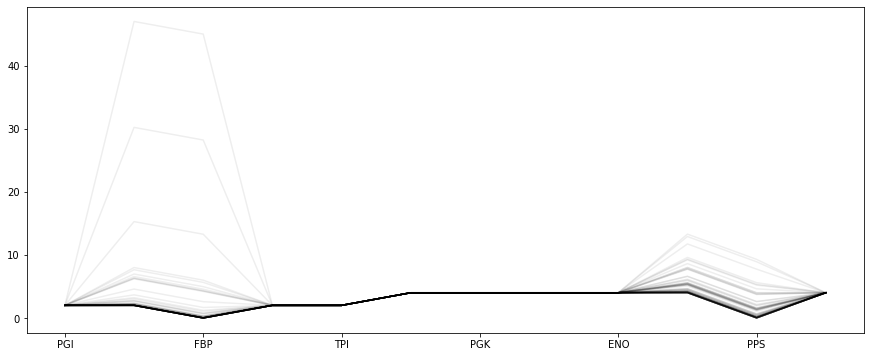

In [20]:
velocity_df.abs()[labels(KB.find(KB.pathways, 'glycolysis')[0].steps)].T.plot(color='#0001', legend=False, figsize=(15,6))

<AxesSubplot:>

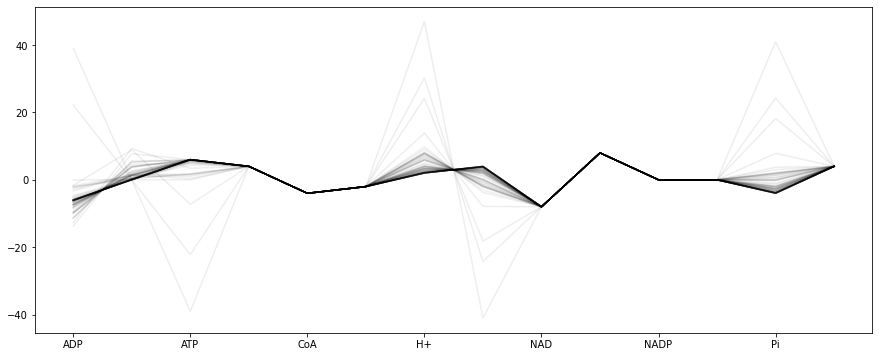

In [21]:
dmdt_df[(sorted(labels(boundaries)))].T.plot(color='#0001', legend=False, figsize=(15,6))

In [22]:
%%time
results = []
for v0s in jax.random.uniform(prng, (100, 21, network.shape[1])):
    v0_ = v0_ = np.median([fba_kinetic.solve(v0=v0).velocities for v0 in v0s], axis=0)
    results.append((fba_kinetic.solve(v0=v0_)))


CPU times: user 1min 12s, sys: 26.9 ms, total: 1min 12s
Wall time: 1min 12s


<AxesSubplot:>

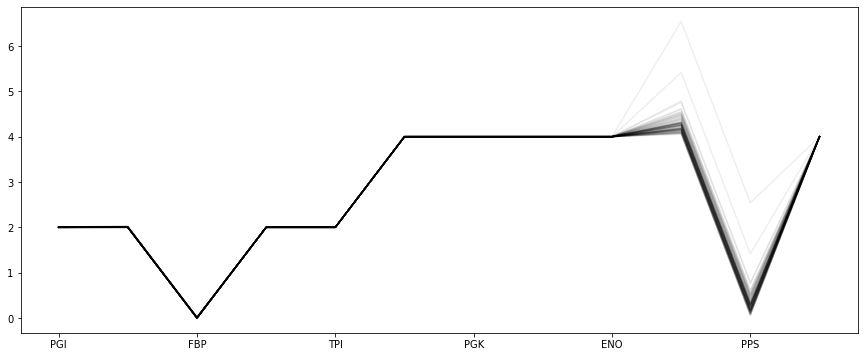

In [23]:
pd.DataFrame([soln.velocities for soln in results], columns=labels(network.reactions())).abs()[labels(KB.find(KB.pathways, 'glycolysis')[0].steps)].T.plot(color='#0001', legend=False, figsize=(15,6))

<AxesSubplot:>

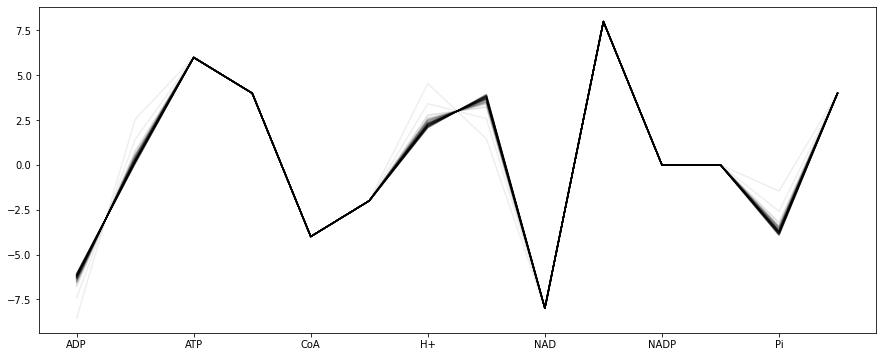

In [24]:
pd.DataFrame([soln.dmdt for soln in results], columns=labels(network.reactants()))[sorted(labels(boundaries))].T.plot(color='#0001', legend=False, figsize=(15,6))